In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNetV2, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [4]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
#early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
#insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
#lrv_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LeafRoll',224))
#virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
#early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
#insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
#lrv_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LeafRoll',224))
#virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 205/205 [00:02<00:00, 102.34it/s]


In [5]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
#early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),1)
healthy_train_label = np.full(len(healthy_train),2)
#insect_train_label = np.full(len(insect_train),4)
#lrv_train_label = np.full(len(lrv_train),5)
#virus_train_label = np.full(len(virus_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
#early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),1)
healthy_test_label = np.full(len(healthy_test),2)
#insect_test_label = np.full(len(insect_test),4)
#lrv_test_label = np.full(len(lrv_test),5)
#virus_test_label = np.full(len(virus_test),6)

In [6]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, late_blight_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, late_blight_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, late_blight_test, healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, late_blight_test_label, healthy_test_label), axis = 0)

In [7]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [8]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [10]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [11]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

mobileNetV2     = MobileNetV2(include_top=False, input_shape=input_shape)(inputs)

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(mobileNetV2)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(3, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 concatenate (Concatenate)   (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120  

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/MobileNetV2(3_classes).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [14]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.6969

60/60 [==============================] - 59s 733ms/step - loss: 0.5486 - accuracy: 0.6969 - val_loss: 1.3496 - val_accuracy: 0.3583 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.8839

60/60 [==============================] - 42s 702ms/step - loss: 0.2835 - accuracy: 0.8839 - val_loss: 1.0515 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9255

60/60 [==============================] - 27s 446ms/step - loss: 0.1872 - accuracy: 0.9255 - val_loss: 0.5281 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.1746 - accuracy: 0.9198

60/60 [==============================] - 30s 502ms/step - loss: 0.1746 - accuracy: 0.9198 - val_loss: 0.2959 - val_accuracy: 0.8479 - lr: 1.0000e-04
Epoch 5/50
60/60 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9333

60/60 [==============================] - 27s 453ms/step - loss: 0.1445 - accuracy: 0.9333 - val_loss: 0.2143 - val_accuracy: 0.8979 - lr: 1.0000e-04
Epoch 6/50
60/60 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9516

60/60 [==============================] - 27s 449ms/step - loss: 0.1133 - accuracy: 0.9516 - val_loss: 0.1793 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 7/50
60/60 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9615

60/60 [==============================] - 27s 451ms/step - loss: 0.0999 - accuracy: 0.9615 - val_loss: 0.1357 - val_accuracy: 0.9354 - lr: 1.0000e-04
Epoch 8/50
60/60 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9547

60/60 [==============================] - 29s 476ms/step - loss: 0.1058 - accuracy: 0.9547 - val_loss: 0.0688 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 9/50
60/60 [==============================] - ETA: 0s - loss: 0.1047 - accuracy: 0.9521

60/60 [==============================] - 28s 471ms/step - loss: 0.1047 - accuracy: 0.9521 - val_loss: 0.0972 - val_accuracy: 0.9521 - lr: 1.0000e-04
Epoch 10/50
60/60 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9599

60/60 [==============================] - 28s 467ms/step - loss: 0.0913 - accuracy: 0.9599 - val_loss: 0.0666 - val_accuracy: 0.9750 - lr: 1.0000e-04
Epoch 11/50
60/60 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9646

60/60 [==============================] - 28s 466ms/step - loss: 0.0893 - accuracy: 0.9646 - val_loss: 0.0627 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 12/50
60/60 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9688

60/60 [==============================] - 27s 443ms/step - loss: 0.0784 - accuracy: 0.9688 - val_loss: 0.1297 - val_accuracy: 0.9333 - lr: 1.0000e-04
Epoch 13/50
60/60 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9620

60/60 [==============================] - 27s 440ms/step - loss: 0.0855 - accuracy: 0.9620 - val_loss: 0.0386 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 14/50
60/60 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9641

60/60 [==============================] - 26s 435ms/step - loss: 0.0808 - accuracy: 0.9641 - val_loss: 0.0712 - val_accuracy: 0.9729 - lr: 1.0000e-04
Epoch 15/50
60/60 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9625

60/60 [==============================] - 27s 447ms/step - loss: 0.0793 - accuracy: 0.9625 - val_loss: 0.1808 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 16/50
60/60 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9641

60/60 [==============================] - 28s 459ms/step - loss: 0.0755 - accuracy: 0.9641 - val_loss: 0.0680 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 17/50
60/60 [==============================] - ETA: 0s - loss: 0.0752 - accuracy: 0.9625

60/60 [==============================] - 28s 466ms/step - loss: 0.0752 - accuracy: 0.9625 - val_loss: 0.0890 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 18/50
60/60 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9641

60/60 [==============================] - 28s 467ms/step - loss: 0.0727 - accuracy: 0.9641 - val_loss: 0.0405 - val_accuracy: 0.9833 - lr: 1.0000e-04
Epoch 19/50
60/60 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9604

60/60 [==============================] - 28s 467ms/step - loss: 0.0780 - accuracy: 0.9604 - val_loss: 0.0303 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 20/50
60/60 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9693

60/60 [==============================] - 28s 461ms/step - loss: 0.0674 - accuracy: 0.9693 - val_loss: 0.0380 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 21/50
60/60 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9682

60/60 [==============================] - 26s 436ms/step - loss: 0.0662 - accuracy: 0.9682 - val_loss: 0.0277 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 22/50
60/60 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9776

60/60 [==============================] - 26s 437ms/step - loss: 0.0544 - accuracy: 0.9776 - val_loss: 0.0175 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 23/50
60/60 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9719

60/60 [==============================] - 26s 438ms/step - loss: 0.0617 - accuracy: 0.9719 - val_loss: 0.0255 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 24/50
60/60 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9734

60/60 [==============================] - 26s 437ms/step - loss: 0.0618 - accuracy: 0.9734 - val_loss: 0.0188 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 25/50
60/60 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9745

60/60 [==============================] - 27s 450ms/step - loss: 0.0656 - accuracy: 0.9745 - val_loss: 0.0155 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 26/50
60/60 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9672

60/60 [==============================] - 28s 462ms/step - loss: 0.0629 - accuracy: 0.9672 - val_loss: 0.0165 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 27/50
60/60 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9714

60/60 [==============================] - 28s 466ms/step - loss: 0.0601 - accuracy: 0.9714 - val_loss: 0.0061 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 28/50
60/60 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9693

60/60 [==============================] - 28s 463ms/step - loss: 0.0588 - accuracy: 0.9693 - val_loss: 0.0063 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 29/50
60/60 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9625

60/60 [==============================] - 28s 472ms/step - loss: 0.0728 - accuracy: 0.9625 - val_loss: 0.0176 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 30/50
60/60 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9781

60/60 [==============================] - 27s 455ms/step - loss: 0.0512 - accuracy: 0.9781 - val_loss: 0.0174 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 31/50
60/60 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9766

60/60 [==============================] - 26s 434ms/step - loss: 0.0526 - accuracy: 0.9766 - val_loss: 0.0183 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 32/50
60/60 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9786

60/60 [==============================] - 26s 432ms/step - loss: 0.0479 - accuracy: 0.9786 - val_loss: 0.0147 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 33/50
60/60 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9740

60/60 [==============================] - 26s 429ms/step - loss: 0.0514 - accuracy: 0.9740 - val_loss: 0.0091 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 34/50
60/60 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9755

60/60 [==============================] - 28s 456ms/step - loss: 0.0478 - accuracy: 0.9755 - val_loss: 0.0102 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 35/50
60/60 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9719

60/60 [==============================] - 28s 468ms/step - loss: 0.0549 - accuracy: 0.9719 - val_loss: 0.0668 - val_accuracy: 0.9688 - lr: 1.0000e-04
Epoch 36/50
60/60 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9734

60/60 [==============================] - 28s 464ms/step - loss: 0.0544 - accuracy: 0.9734 - val_loss: 0.0119 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 37/50
60/60 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9740

60/60 [==============================] - 28s 465ms/step - loss: 0.0504 - accuracy: 0.9740 - val_loss: 0.0085 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 38/50
60/60 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9729

60/60 [==============================] - 28s 466ms/step - loss: 0.0575 - accuracy: 0.9729 - val_loss: 0.0133 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 39/50
60/60 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9776

60/60 [==============================] - 27s 450ms/step - loss: 0.0517 - accuracy: 0.9776 - val_loss: 0.0115 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 40/50
60/60 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9807

60/60 [==============================] - 26s 436ms/step - loss: 0.0419 - accuracy: 0.9807 - val_loss: 0.0125 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 41/50
60/60 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9812

60/60 [==============================] - 28s 463ms/step - loss: 0.0448 - accuracy: 0.9812 - val_loss: 0.0136 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 42/50
60/60 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9750

60/60 [==============================] - 28s 466ms/step - loss: 0.0570 - accuracy: 0.9750 - val_loss: 0.0130 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 43/50
60/60 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9771

60/60 [==============================] - 28s 474ms/step - loss: 0.0496 - accuracy: 0.9771 - val_loss: 0.0094 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 44/50
60/60 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9792

60/60 [==============================] - 29s 484ms/step - loss: 0.0466 - accuracy: 0.9792 - val_loss: 0.0075 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 45/50
60/60 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9781

60/60 [==============================] - 28s 467ms/step - loss: 0.0425 - accuracy: 0.9781 - val_loss: 0.0024 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 46/50
60/60 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9771

60/60 [==============================] - 26s 439ms/step - loss: 0.0505 - accuracy: 0.9771 - val_loss: 0.0040 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 47/50
60/60 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9771

60/60 [==============================] - 27s 445ms/step - loss: 0.0477 - accuracy: 0.9771 - val_loss: 0.0085 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 48/50
60/60 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9802

60/60 [==============================] - 26s 428ms/step - loss: 0.0403 - accuracy: 0.9802 - val_loss: 0.0058 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 49/50
60/60 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9776

60/60 [==============================] - 28s 459ms/step - loss: 0.0473 - accuracy: 0.9776 - val_loss: 0.0045 - val_accuracy: 0.9979 - lr: 1.0000e-04
Epoch 50/50
60/60 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9766

60/60 [==============================] - 28s 463ms/step - loss: 0.0450 - accuracy: 0.9766 - val_loss: 0.0138 - val_accuracy: 0.9937 - lr: 1.0000e-04


20/20 [==============================] - 2s 67ms/step
Confusion matrix, without normalization
[[205   0   1]
 [  1 199   0]
 [  5   0 200]]


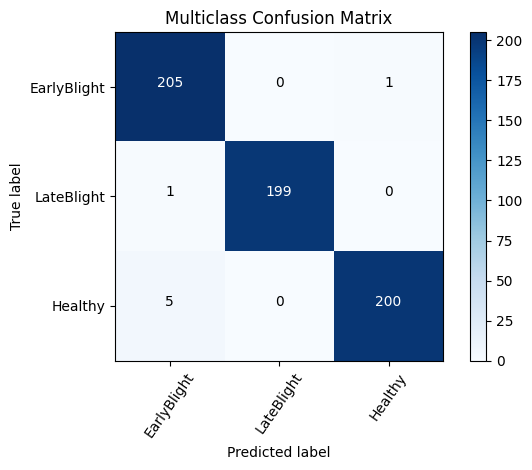

In [15]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlight', 'LateBlight','Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

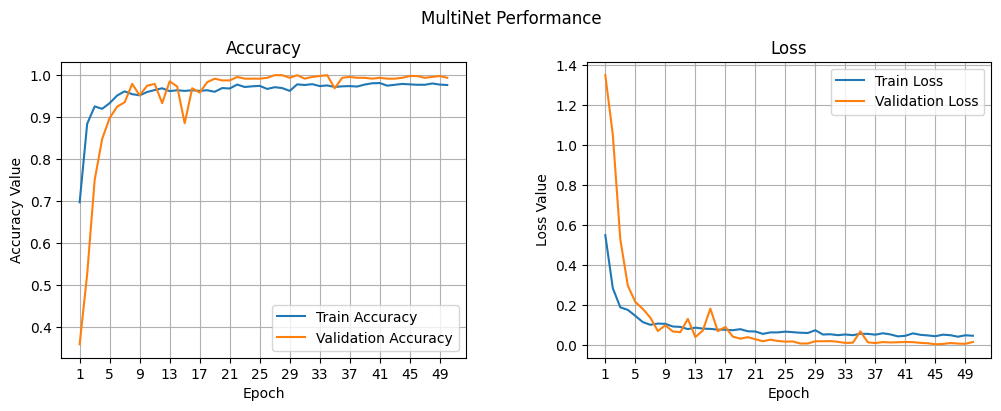

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 51, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 51, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight', 'LateBlight', 'Healthy']
print(classification_report(y_test, Y_pred, target_names=target_names))

20/20 [==============================] - 1s 38ms/step
Classification Report
              precision    recall  f1-score   support

 EarlyBlight       0.97      1.00      0.98       206
  LateBlight       1.00      0.99      1.00       200
     Healthy       1.00      0.98      0.99       205

    accuracy                           0.99       611
   macro avg       0.99      0.99      0.99       611
weighted avg       0.99      0.99      0.99       611



In [18]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MobileNetV2")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

20/20 [==============================] - 1s 33ms/step
MobileNetV2
Accuracy: 0.9885433715220949
F1 Score: 0.9885251118759736
precision: 0.9886715043059731
recall: 0.9885433715220949
MSE: 0.04091653027823241
MAE: 0.02127659574468085


In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

20/20 [==============================] - 1s 33ms/step


In [20]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc

0.9805959389643157

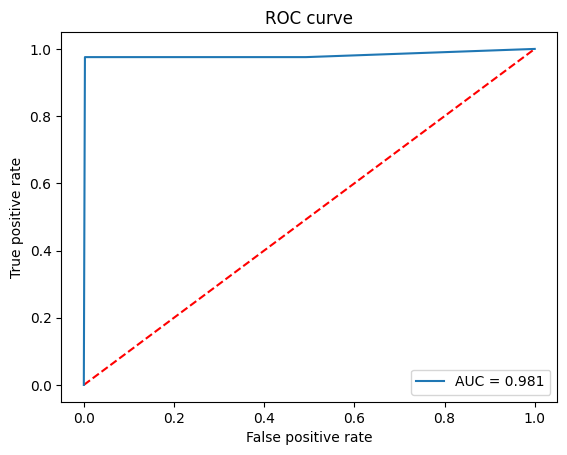

In [21]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
